In [1]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from scipy.stats import norm
import matplotlib.pyplot as plt

<!-- Initialization:
    Set initial values for means, covariances, and weights.
    These parameters represent the centers, spreads, and importance of Gaussian components in the Gaussian Mixture Model (GMM).

Expectation (E-step):
    Compute the responsibilities, indicating the likelihood of each data point belonging to each component.
    Use current estimates of means, covariances, and weights.

Maximization (M-step):
    Update the means by computing weighted averages of data points using responsibilities.
    Update covariances by computing weighted averages of outer products of deviations from the updated means.
    Update weights by computing the mean of responsibilities for each component.

Iterate:
    Repeat the E-step and M-step for a fixed number of iterations or until convergence.
    The E-step refines component assignments based on current parameter estimates, and the M-step updates parameters based on these assignments.

Convergence Check:
    Monitor a convergence criterion, such as the change in log-likelihood, to determine if the algorithm has sufficiently converged.
    Stop iterating if convergence is achieved.

Result:
    The final estimates of means, covariances, and weights represent the parameters of the GMM that best explain the observed data.
    These parameters capture the underlying structure of the data in terms of Gaussian components. -->

Initialization:
- Set initial values for means, covariances, and weights.
- These parameters represent the centers, spreads, and importance of Gaussian components in the Gaussian Mixture Model (GMM).

Expectation (E-step):
- Compute the responsibilities, indicating the likelihood of each data point belonging to each component.
- Use current estimates of means, covariances, and weights.

Maximization (M-step):
- Update the means by computing weighted averages of data points using responsibilities.
- Update covariances by computing weighted averages of outer products of deviations from the updated means.
- Update weights by computing the mean of responsibilities for each component.

Iterate:
- Repeat the E-step and M-step for a fixed number of iterations or until convergence.
- The E-step refines component assignments based on current parameter estimates, and the M-step updates parameters based on these assignments.

Convergence Check:
- Monitor a convergence criterion, such as the change in log-likelihood, to determine if the algorithm has sufficiently converged.
- Stop iterating if convergence is achieved.

Result:
- The final estimates of means, covariances, and weights represent the parameters of the GMM that best explain the observed data.
- These parameters capture the underlying structure of the data in terms of Gaussian components.

In [2]:
# ID for randomizing order
np.random.seed(5)

# Create synthetic data
n_samples = 1000
n_features = 2        # number of feature columns
n_components = 2      # number of unique classes (i.e, clusters)

"""
X_1 (Income) | X_2 (Skills) | Z (Class)
120k      10      2             A
80k       7       1             B
20m       3       3             A
"""

'\nX_1 (Income) | X_2 (Skills) | Z (Class)\n120k      10      2             A\n80k       7       1             B\n20m       3       3             A\n'

Parameters of $X_1$
- $\mu_1$ is the mean average of $X_1$
- $\mathbf{\Sigma}_1$ is the covariance matrix of $X_1$
- $X_1$ is the first feature

In [3]:
# Parameters for X_1
mean_1 = np.array([0, 0])
cov_1 = np.array(
    [
      [1, 0],
      [0, 1]
    ]
)
X_1 = np.random.multivariate_normal(mean_1, cov_1, n_samples)

In [4]:
# Parameters for X_2
mean_2 = np.array([0, 0])
cov_2 = np.array(
    [
      [1, 0],
      [0, 1]
    ]
)
X_2 = np.random.multivariate_normal(mean_2, cov_2, n_samples)

In [5]:
print(X_1)

[[ 0.44122749 -0.33087015]
 [ 2.43077119 -0.25209213]
 [ 0.10960984  1.58248112]
 ...
 [-0.61818034  1.39191346]
 [ 0.62061348  0.7042333 ]
 [-1.18573437 -3.50747462]]


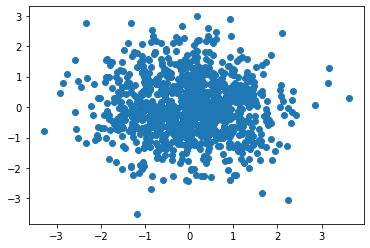

In [6]:
plt.scatter(X_1[:, 0],X_1[:, 1])

(array([  2.,  15.,  34., 113., 231., 255., 195., 106.,  39.,  10.]),
 array([-3.50747462, -2.85858669, -2.20969876, -1.56081083, -0.9119229 ,
        -0.26303497,  0.38585296,  1.03474089,  1.68362882,  2.33251675,
         2.98140467]),
 <BarContainer object of 10 artists>)

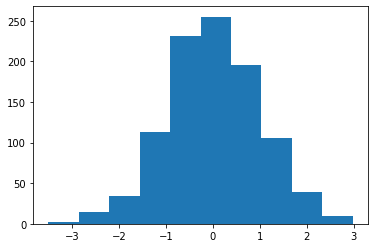

In [7]:
plt.hist(X_1[:, 1])

In [8]:
# Form the matrix containing all features
X = np.concatenate((X_1, X_2))

### EM Algorithm

$I = \begin{bmatrix} 1 & 0 \\ 0 & 1\end{bmatrix}$ <br/>
$ c = 2$  <br/><br/>

$ I \times c = C $

$$
\gamma(z_{ij}) = \frac{\pi_j \mathcal{N}(x_i | \mu_j, \Sigma_j)}{\sum_{k=1}^{K} \pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k)}
$$

**Update Means:**

$$
\mu_j = \frac{\sum_{i=1}^{N} \gamma(z_{ij}) x_i}{\sum_{i=1}^{N} \gamma(z_{ij})}
$$

**Update Covariances:**

$$
\Sigma_j = \frac{\sum_{i=1}^{N} \gamma(z_{ij}) (x_i - \mu_j)(x_i - \mu_j)^\top}{\sum_{i=1}^{N} \gamma(z_{ij})}
$$

**Update Weights:**

$$
\pi_j = \frac{1}{N} \sum_{i=1}^{N} \gamma(z_{ij})
$$


In [9]:
# Initialize the prior parameters
init_means  = [
    np.array([-1, -1]),
    np.array([2, 2])
]

init_covariance = [np.eye(n_features)] * n_components
init_weights = [0.5, 0.5]

In [10]:
def E_step(X, means, covariance_matrices, weights):
  n_samples = X.shape[0]
  n_components = len(means)
  responsibilities = np.zeros((n_samples, n_components))
  # Go through every cell matrix
  for i in range(n_samples):
    for j in range(n_components):
      responsibilities[i, j] = weights[j] * multivariate_normal.pdf(X[i], means[j], covariance_matrices[j])
    responsibilities[i] /= np.sum(responsibilities[i])
  return responsibilities


# M-step: Update the parameters (means, covariances, weights)
def M_step(X, responsibilities):
    n_samples, n_components = responsibilities.shape
    n_features = X.shape[1]

    # Update the means
    means = np.zeros((n_components, n_features))
    for j in range(n_components):
        for i in range(n_samples):
            means[j] += responsibilities[i, j] * X[i]
        means[j] /= np.sum(responsibilities[:, j])

    # Update the covariances
    covariances = np.zeros((n_components, n_features, n_features))
    for j in range(n_components):
        for i in range(n_samples):
            diff = X[i] - means[j]
            covariances[j] += responsibilities[i, j] * np.outer(diff, diff)
        covariances[j] /= np.sum(responsibilities[:, j])

    # Update the weights
    weights = np.mean(responsibilities, axis=0)

    return means, covariances, weights

In [11]:
# Expectation-Maximization (EM) algorithm
means = init_means
covariances = init_covariance
weights = init_weights

for _ in range(10):  # Run the algorithm for a fixed number of iterations
    # E-step: Update the responsibilities
    responsibilities = E_step(X, means, covariances, weights)

    # M-step: Update the parameters
    means, covariances, weights = M_step(X, responsibilities)

print("Estimated Means:")
print(means)
print("Estimated Covariances:")
print(covariances)
print("Estimated Weights:")
print(weights)

Estimated Means:
[[-0.20336134 -0.19298192]
 [ 0.59459483  0.68661213]]
Estimated Covariances:
[[[ 0.9718367  -0.09051901]
  [-0.09051901  0.90509662]]

 [[ 0.79466154 -0.1708392 ]
  [-0.1708392   0.70127224]]]
Estimated Weights:
[0.74790135 0.25209865]


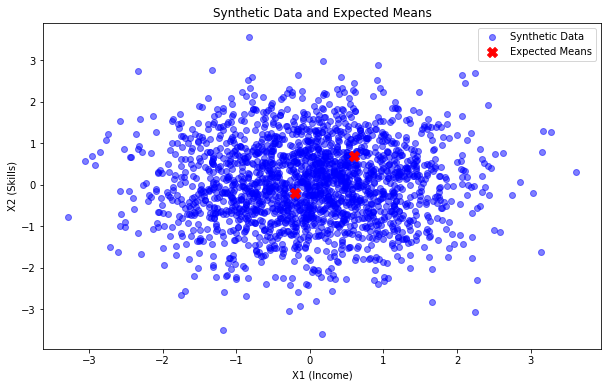

In [12]:
import seaborn as sns

# Visualize the synthetic data
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c='blue', alpha=0.5, label='Synthetic Data')
plt.title('Synthetic Data and Expected Means')
plt.xlabel('X1 (Income)')
plt.ylabel('X2 (Skills)')

# Plot the expected means
plt.scatter(means[:, 0], means[:, 1], c='red', marker='X', s=100, label='Expected Means')
plt.legend()
plt.show()


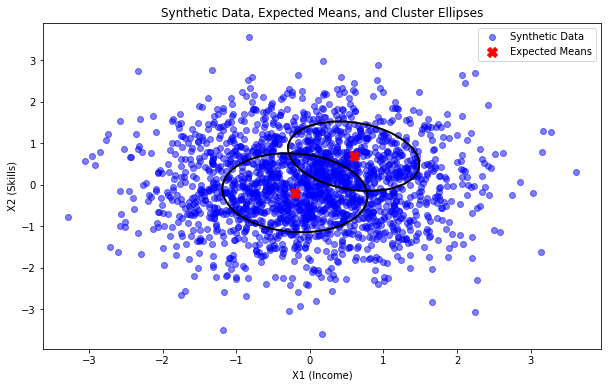

In [13]:
import seaborn as sns
from matplotlib.patches import Ellipse

# Visualize the synthetic data and expected means
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c='blue', alpha=0.5, label='Synthetic Data')
plt.scatter(means[:, 0], means[:, 1], c='red', marker='X', s=100, label='Expected Means')

# Plot ellipses for the clusters
for i in range(n_components):
    cov_matrix = covariances[i]
    mean = means[i]

    # Get eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # Calculate the angle of rotation for the ellipse
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

    # Plot the ellipse
    ellipse = Ellipse(xy=mean, width=2 * np.sqrt(eigenvalues[0]), height=2 * np.sqrt(eigenvalues[1]),
                      angle=angle, edgecolor='black', fc='None', lw=2)
    plt.gca().add_patch(ellipse)

plt.title('Synthetic Data, Expected Means, and Cluster Ellipses')
plt.xlabel('X1 (Income)')
plt.ylabel('X2 (Skills)')
plt.legend()
plt.show()
